In [1]:
# Import the necessary packages
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN

<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).


In [2]:
# Import population grid of respective urban area
popgrid = gpd.read_file('popgridmanchesterlatest.gpkg')

In [3]:
# Selecting variables (columns) of interest
popgridsub = popgrid.iloc[:,[4,11,18,21,22,25,27,30,31]+list(range(36,60))]

# Variables of interest
cluster_variables = [col for col in popgridsub.columns if col != "geometry"]

# Converting population density per buffer to km2, will do this for the main gdf
popgridsub.buffer_pop_density = popgridsub.buffer_pop_density*1000000

# Remove nans and inf values, resetting index
popgridsub = popgridsub.replace([np.inf, -np.inf], np.nan)
popgridsub = popgridsub.dropna()
popgridsub = popgridsub.reset_index()

# Robust scaling due to the range of values differing between variables
popgridsub_scaled = scale(popgridsub[cluster_variables])

c:\Users\Gebruiker\anaconda3\envs\ssml\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
dbscan = DBSCAN(eps=2, min_samples=1000)

In [5]:
dbscan = dbscan.fit(popgridsub_scaled)

In [6]:
dbscan.labels_[:5]

array([-1, -1, -1, -1, -1], dtype=int64)

In [7]:
# Assign cluster labels to a new column
popgridsub["dbscan_clustering_labels"] = dbscan.labels_

In [8]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(popgridsub["dbscan_clustering_labels"])) - (1 if -1 in popgridsub["dbscan_clustering_labels"] else 0)
n_noise_ = list(popgridsub["dbscan_clustering_labels"]).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 264879


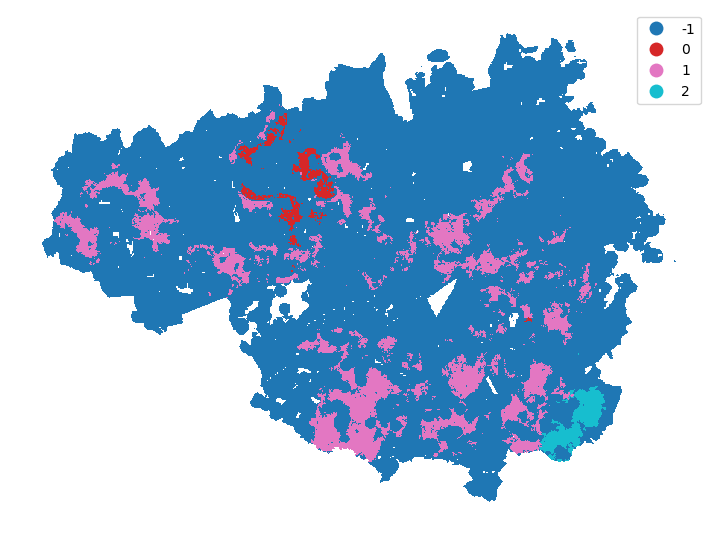

In [12]:
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="dbscan_clustering_labels",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()